In [38]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征 X∈R1000×2X∈R 1000×2 ，我们使用线性回归模型真实权重 w=[2,−3.4]⊤w=[2,−3.4] ⊤ 和偏差 b=4.2b=4.2，以及一个随机噪声项 ϵϵ 来生成标签

其中噪声项 ϵϵ 服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [39]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

In [40]:
features

tensor([[-1.2552, -1.2899],
        [ 0.9834, -2.0243],
        [-0.0423,  0.4665],
        ...,
        [ 0.3056,  0.2927],
        [ 0.5947,  0.1681],
        [ 1.0596, -0.0256]])

In [41]:
labels

tensor([ 6.0719, 13.0465,  2.5433,  9.2345,  5.6781, -3.6968, -3.5111,  1.2196,
         5.9844, 12.5707,  2.3628,  1.2964,  5.9221,  6.5626, -0.3485,  4.2958,
         7.7098,  5.9825,  6.5083,  9.4869,  9.9762,  2.4817,  3.3843, -1.5520,
         3.7397,  2.7542,  6.5724,  2.0137,  5.8543,  2.6830,  4.3087,  2.3457,
         6.1002,  4.1338,  9.3715,  9.1866,  3.8909,  2.1908,  3.8657,  3.8158,
         6.6713,  7.5490,  0.9036, 10.9680, 11.0973,  6.4197,  0.4942,  4.5510,
         2.5678,  3.2984,  5.5457, -1.2339,  9.9874, -1.4995,  5.7089,  0.6061,
         4.8906, -6.1130,  5.0202,  7.0408,  0.8700,  0.6894,  2.9701,  6.6779,
         8.8868,  5.4876,  2.9887,  4.3244, -4.2390, -0.1369,  1.3348,  3.0305,
         7.2840,  5.4176, -4.3303, 10.8204,  6.4588,  3.7919,  4.7744, 12.5337,
         7.8433,  2.4919,  4.8350,  6.5784,  1.8543,  4.0825,  6.2878, -3.9754,
         1.8271, -2.8437, 10.8535,  3.4223,  1.8182,  5.1517,  4.5645,  2.1236,
        10.0039,  6.6318,  0.3300,  1.94

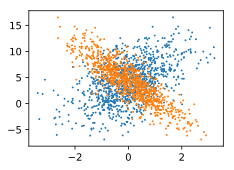

In [42]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 0].numpy(), labels.numpy(), 1)
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)
plt.show()

In [43]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
#     print(indices)
    random.shuffle(indices)  # 样本的读取顺序是随机的
#     print(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


tensor([[-1.2006e+00, -4.3062e-01],
        [ 8.6042e-01, -4.7241e-01],
        [-3.3801e-04,  1.1086e+00],
        [-1.9818e-01,  5.7711e-02],
        [ 1.1015e+00, -1.1576e-01],
        [ 2.1261e-01, -1.3127e+00],
        [-1.6239e+00, -1.8277e+00],
        [-1.3338e+00, -9.4480e-02],
        [ 2.5131e+00, -1.9809e-01],
        [-1.7712e-01, -5.1416e-01]]) tensor([3.2676, 7.5249, 0.4349, 3.6161, 6.7902, 9.0857, 7.1776, 1.8728, 9.8694,
        5.6097])


In [66]:
# 我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

In [67]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

In [68]:
lr = 0.03        # 步长（自定）
num_epochs = 3   # 梯度下降迭代次数（自定）
net = linreg     # 模型（线性回归）
loss = squared_loss    # 损失函数

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))


epoch 1, loss 0.036892
epoch 2, loss 0.000139
epoch 3, loss 0.000052


In [69]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9994],
        [-3.3991]], requires_grad=True)
4.2 
 tensor([4.2002], requires_grad=True)


我们生成与上一节中相同的数据集。其中features是训练数据特征，labels是标签。

In [70]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

PyTorch提供了data包来读取数据。由于data常用作变量名，我们将导入的data模块用Data代替。在每一次迭代中，我们将随机读取包含10个数据样本的小批量。

In [71]:
import torch.utils.data as Data

batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

这里data_iter的使用跟上一节中的一样。让我们读取并打印第一个小批量数据样本。

In [72]:
for X, y in data_iter:
    print(X, y)
    break

tensor([[-1.2754, -0.3744],
        [ 0.8558, -1.2553],
        [ 0.8704, -1.1822],
        [ 0.8191,  0.0468],
        [ 0.2587,  0.1949],
        [-2.2558, -0.1377],
        [-0.8761, -2.3307],
        [-1.0027, -0.9408],
        [ 0.8792, -0.9991],
        [-1.1853,  0.2948]]) tensor([ 2.9174, 10.1805,  9.9465,  5.6871,  4.0545,  0.1623, 10.3734,  5.3968,
         9.3546,  0.8311])


在上一节从零开始的实现中，我们需要定义模型参数，并使用它们一步步描述模型是怎样计算的。当模型结构变得更复杂时，这些步骤将变得更繁琐。其实，PyTorch提供了大量预定义的层，这使我们只需关注使用哪些层来构造模型。下面将介绍如何使用PyTorch更简洁地定义线性回归。

首先，导入torch.nn模块。实际上，“nn”是neural networks（神经网络）的缩写。顾名思义，该模块定义了大量神经网络的层。之前我们已经用过了autograd，而nn就是利用autograd来定义模型。nn的核心数据结构是Module，它是一个抽象概念，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承nn.Module，撰写自己的网络/层。一个nn.Module实例应该包含一些层以及返回输出的前向传播（forward）方法。下面先来看看如何用nn.Module实现一个线性回归模型。

In [74]:
import torch.nn as nn
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)
print(net) # 使用print可以打印出网络的结构

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [89]:
# 写法一
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 此处还可以传入其他层
    )

# 写法二
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [90]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[0.6898, 0.6350]], requires_grad=True)
Parameter containing:
tensor([0.4885], requires_grad=True)


In [96]:
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0)  # 也可以直接修改bias的data: net[0].bias.data.fill_(0)
# init.normal_(net.linear.weight, mean=0, std=0.01)
# init.constant_(net.linear.bias, val=0)

Parameter containing:
tensor([0.], requires_grad=True)

In [97]:
loss = nn.MSELoss()

In [98]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)


SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [101]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000087
epoch 2, loss: 0.000107
epoch 3, loss: 0.000120


In [102]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 1.9997, -3.3999]], requires_grad=True)
4.2 Parameter containing:
tensor([4.2000], requires_grad=True)
